I have been using [dask](https://dask.org/) for speeding up some larger scale analyses. Dask is a really great tool for inplace replacement for parrallelizing some [pyData](https://pydata.org/downloads/)-powered analyses, such as [numpy](http://docs.dask.org/en/latest/array-creation.html#create-dask-arrays), [pandas](http://docs.dask.org/en/latest/array-creation.html#from-dask-dataframe) and even [scikit-learn](https://ml.dask.org/#dask-ml).  

However, I recently found an interesting case where using same syntax in ***dask.dataframe*** for ***pandas.dataframe*** does not acheive what I want. So in this post, I will document how to overcome it for future self.


As usual, lets import all the useful libraries:

In [3]:
import pandas as pd
import dask.dataframe as dd

I will use the famous [titanic dataset](https://www.kaggle.com/c/titanic) as an example to show that how **dask** can act weirdly under *groupby + apply* operations.

In [10]:
titanic = pd.read_csv('http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


 I will illustrate the problem by counting how many survivors in each age and sex group, using the following function:

In [8]:
def count_survival(d):
    '''
    summarize survivor, and return an dataframe for the single value-ed array
    '''
    return pd.DataFrame({'survived':[d.Survived.sum()]})

An regular **pandas** way to do it would be:

In [14]:
titanic    \
    .groupby(['Age','Sex'])\
    .apply(count_survival)\
    .head()

,,,survived
Age,Sex,,
0.42,male,0,1
0.67,male,0,1
0.75,female,0,2
0.83,male,0,2
0.92,male,0,1


Lets translate the ***pandas.dataframe*** to a ***dask.dataframe*** and do the same

In [16]:
dask_job = titanic \
    .pipe(dd.from_pandas, npartitions=24)\
    .groupby(['Age','Sex']) \
    .apply(count_survival, meta={'survived':'f8'}) 

This is not going to return any result until we do ```dask_job.compute()```, but **dask** also include a *visualize* function to show the task graph:

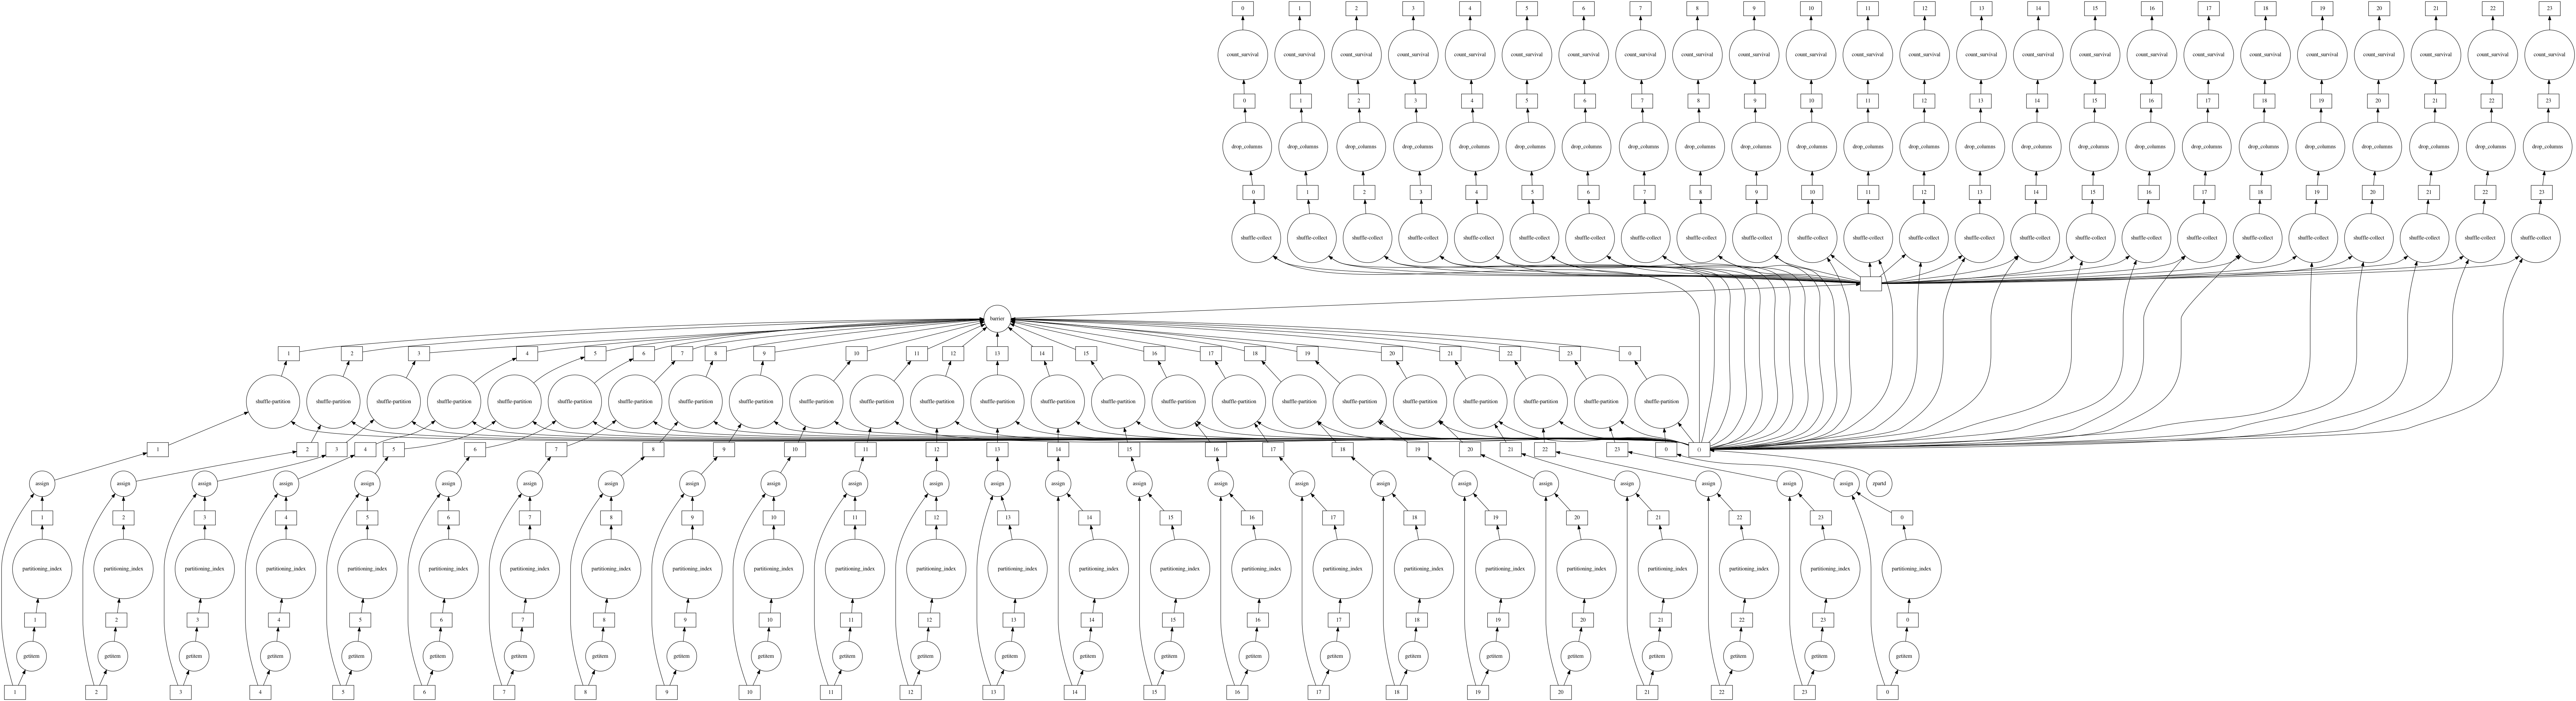

In [18]:
dask_job.visualize()

The resultant task graph is much more complicated than I would've expected, and this is actually because [data shuffling](http://docs.dask.org/en/latest/dataframe-groupby.html) behind the scene. Suggested by [the dask documentation](http://docs.dask.org/en/latest/dataframe-groupby.html#difficult-cases), this issue can be resolved by setting a groupby key as index:

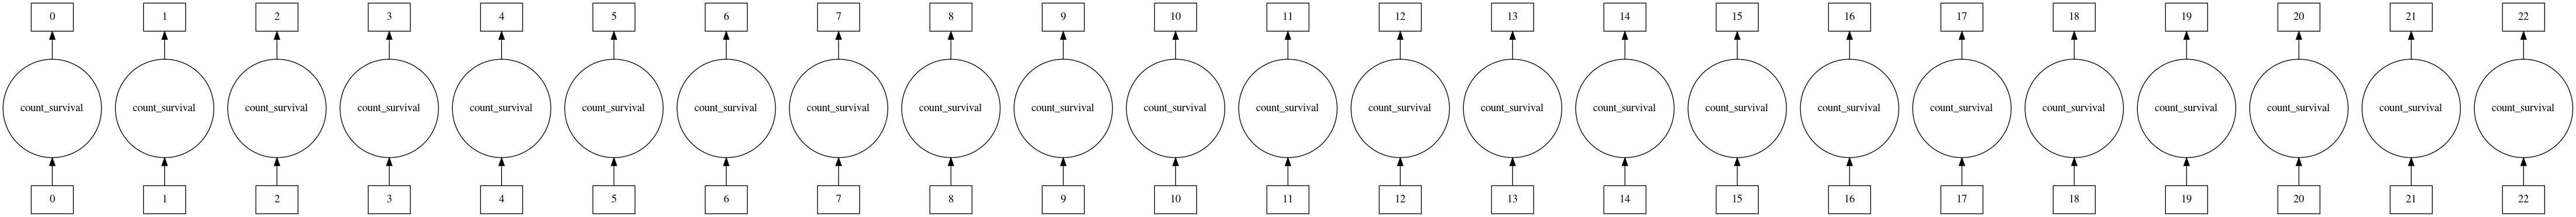

In [21]:
dask_job = titanic \
    .set_index('Age')\
    .pipe(dd.from_pandas, npartitions=24)\
    .groupby(['Age','Sex']) \
    .apply(count_survival, meta={'survived':'f8'}) 
dask_job.visualize()